In [1]:
import h5py
import copy
import lmfit
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from rich.progress import Progress
from scipy.stats import binned_statistic
from utils.plot_utils import set_fontsize
from utils.hdf_utils import load_measurement_data_devices_attrs

In [2]:
def ratio_with_error(a,b,σa,σb):
    ratio = a/b
    err = ratio * np.sqrt((σa/a)**2 + (σb/b)**2)
    return ratio, err

In [3]:
hdf_dir = Path("../data")

In [7]:
yag_channel = 0
pmt_channel = 1
pd_channel = 2
pdn_channel = 3
shutter_channel = 4
pdrc_channel = 5

In [8]:
fname = "2021_3_5.hdf"

with h5py.File(hdf_dir / fname, 'r') as f:
    dset_names = list(f.keys())
dset_names

['1614977805 scan R0 F1',
 '1614978907 scan P2 F1',
 '1614978965 scan P2 F1',
 '1614980016 scan J12 microwaves',
 '1614983082 scan P2 F1 with microwaves']

In [9]:
dset_name = "1614983082 scan P2 F1 with microwaves"
devices = ()

In [10]:
slice_flm  = np.s_[100:250]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [8]:
scan_parameter = "Laser Lock 1 SetLockPointSeed1"

In [9]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

dset_len = yag_data[0].size

total_len = int((nbunch) * (yag_data.size//(dset_len*nbunch)))

yag_data = yag_data[:total_len]
pmt_data = pmt_data[:total_len]
pd_data = pd_data[:total_len]
pdn_data = pdn_data[:total_len]
norm_data = norm_data[:total_len]
shutter_data = shutter_data[:total_len]

In [10]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

mask_yag = yag_data.max(axis = 1) < 500
mask_abs = np.trapz(norm_data_norm[:,slice_absi], axis = 1) < 0.7

mask = mask_yag | mask_abs

pmt_data_norm[mask] = np.nan
norm_data_norm[mask] = np.nan

In [11]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

bin_width = np.diff(np.unique(scan_parameters)).min()
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width/2, bin_width)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat, bin_edges, bin_number = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanmean(x), bins = bins)
    err, _, _ = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanstd(x)/np.sqrt(len(x)-1), bins = bins)
    results.append((stat, err, bin_number))
    
bin_means = bin_edges[:-1]+bin_width/2

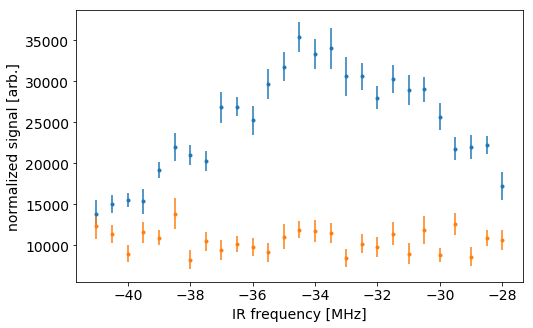

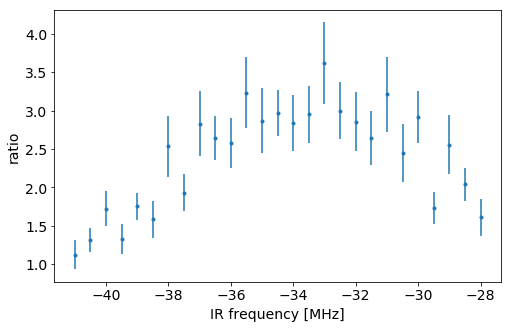

In [12]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

set_fontsize(ax, 14)